In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os
import sys
import time
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nets import *
from cfgs import *
from data import *
from clip_ops.clip_ops import *
from trainer import *

In [2]:
save_alloc_tst = False
save_mis_tst = not save_alloc_tst

In [3]:
%matplotlib inline
save_plot = True
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
D = 11
Dm = 11
Da = 201

if save_alloc_tst:
    Do, gd = Da, 0
if save_mis_tst:
    Do, gd = D, 2000

cfg = additive_1x2_uniform_config.cfg
cfg.test.num_misreports = Dm ** 2
cfg.test.batch_size = Do
cfg.test.num_batches = Do
cfg.test.save_output = True
cfg.test.num_instances = cfg.test.num_batches * cfg.test.batch_size
cfg.test.gd_iter = gd
cfg.test.restore_iter = 20000

In [4]:
x = np.linspace(0, 1.0, D)
X_tst = np.stack([v.flatten() for v in np.meshgrid(x,x)], axis = -1)
X_tst = np.expand_dims(X_tst, 1)
print(X_tst.shape) # D^2, 1, 2

x = np.linspace(0, 1.0, Dm)
ADV = np.stack([v.flatten() for v in np.meshgrid(x,x)], axis = -1)
ADV = np.expand_dims(ADV, 1) # Dm^2, 1, 2
ADV = np.tile(ADV[:, np.newaxis, :, :], [1, D**2, 1, 1])
print(ADV.shape) # Dm^2, D^2, 1, 2

x = np.linspace(0, 1.0, Da)
X_tst_all = np.stack([v.flatten() for v in np.meshgrid(x,x)], axis = -1)
X_tst_all = np.expand_dims(X_tst_all, 1)
print(X_tst_all.shape) # D^2, 1, 2

(121, 1, 2)
(121, 121, 1, 2)
(40401, 1, 2)


In [5]:
net = additive_net.Net(cfg)
if save_alloc_tst:
    generator = uniform_01_generator.Generator(cfg, "test", X_tst_all)
if save_mis_tst:    
    generator = uniform_01_generator.Generator(cfg, "test", X_tst, ADV)
clip_op_lambda = (lambda x: clip_op_01(x))
m = trainer.Trainer(cfg, "test", net, clip_op_lambda)

In [6]:
def test_m(self, generator, save_alloc_tst = False, save_mis_tst = True):
        """
        Runs test
        """
        
        # Init generators
        self.test_gen = generator

        iter = self.config.test.restore_iter
        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()

        model_path = os.path.join(self.config.dir_name,'model-' + str(iter))
        self.saver.restore(sess, model_path)

        #Test-set Stats
        time_elapsed = 0
            
        metric_tot = np.zeros(len(self.metric_names))

        if save_alloc_tst:
            alloc_tst = np.zeros(self.test_gen.X.shape)
            pay_tst = np.zeros(self.test_gen.X.shape[:-1])
            
        if save_mis_tst:
            mis_tst = []
                    
        for i in range(self.config.test.num_batches):
            tic = time.time()
            X, ADV, perm = next(self.test_gen.gen_func)
            sess.run(self.assign_op, feed_dict = {self.adv_init: ADV})
            M = []
            
            if save_mis_tst: M.append(sess.run(self.misreports, feed_dict = {self.x: X}))
                    
            for k in range(self.config.test.gd_iter):
                sess.run(self.test_mis_step, feed_dict = {self.x: X})
                sess.run(self.clip_op)
                if save_mis_tst: M.append(sess.run(self.misreports, feed_dict = {self.x: X}))

            sess.run(self.reset_test_mis_opt)        
                
            metric_vals = sess.run(self.metrics, feed_dict = {self.x: X})
            
            if save_alloc_tst:
                A, P = sess.run([self.alloc, self.pay], feed_dict = {self.x:X})
                alloc_tst[perm, :, :] = A
                pay_tst[perm, :] = P
                
            if save_mis_tst:
                mis_tst.append(M)
                
            
                    
            metric_tot += metric_vals
            toc = time.time()
            time_elapsed += (toc - tic)

            fmt_vals = tuple([ item for tup in zip(self.metric_names, metric_vals) for item in tup ])
            log_str = "TEST BATCH-%d: t = %.4f"%(i, time_elapsed) + ", %s: %.6f"*len(self.metric_names)%fmt_vals
            self.logger.info(log_str)
        
        metric_tot = metric_tot/self.config.test.num_batches
        fmt_vals = tuple([ item for tup in zip(self.metric_names, metric_tot) for item in tup ])
        log_str = "TEST ALL-%d: t = %.4f"%(iter, time_elapsed) + ", %s: %.6f"*len(self.metric_names)%fmt_vals
        self.logger.info(log_str)
            
        if save_alloc_tst:
            np.save(os.path.join(self.config.dir_name, 'alloc_tst_' + str(iter)), alloc_tst)
            np.save(os.path.join(self.config.dir_name, 'pay_tst_' + str(iter)), pay_tst)
            
        if save_mis_tst:
            np.save(os.path.join(self.config.dir_name, 'mis_tst_' + str(iter)), np.asarray(mis_tst))
            

In [7]:
test_m(m, generator, save_alloc_tst, save_mis_tst)

INFO:tensorflow:Restoring parameters from experiments/additive_1x2_uniform/model-20000


2019-02-21 12:47:43,130:INFO:Restoring parameters from experiments/additive_1x2_uniform/model-20000
2019-02-21 12:47:53,943:INFO:TEST BATCH-0: t = 10.7743, Revenue: 0.209041, Regret: 0.002256, IRP: 0.000000
2019-02-21 12:48:01,152:INFO:TEST BATCH-1: t = 17.9804, Revenue: 0.277091, Regret: 0.002215, IRP: 0.000000
2019-02-21 12:48:08,349:INFO:TEST BATCH-2: t = 25.1740, Revenue: 0.349171, Regret: 0.002406, IRP: 0.000000
2019-02-21 12:48:15,607:INFO:TEST BATCH-3: t = 32.4295, Revenue: 0.424323, Regret: 0.002581, IRP: 0.000000
2019-02-21 12:48:22,799:INFO:TEST BATCH-4: t = 39.6191, Revenue: 0.501648, Regret: 0.002601, IRP: 0.000000
2019-02-21 12:48:29,999:INFO:TEST BATCH-5: t = 46.8168, Revenue: 0.580461, Regret: 0.002573, IRP: 0.000000
2019-02-21 12:48:37,266:INFO:TEST BATCH-6: t = 54.0819, Revenue: 0.660341, Regret: 0.002582, IRP: 0.000000
2019-02-21 12:48:44,458:INFO:TEST BATCH-7: t = 61.2714, Revenue: 0.739251, Regret: 0.002645, IRP: 0.000000
2019-02-21 12:48:51,648:INFO:TEST BATCH-8: t

In [8]:
alloc = np.load(os.path.join(cfg.dir_name, "alloc_tst_" + str(cfg.test.restore_iter) + ".npy"))
pay = np.load(os.path.join(cfg.dir_name, "pay_tst_" + str(cfg.test.restore_iter) + ".npy"))

In [9]:
mis = np.load(os.path.join(cfg.dir_name, "mis_tst_" + str(cfg.test.restore_iter) + ".npy"))
mis = mis.reshape(mis.shape[0], mis.shape[1], Dm**2, D, mis.shape[-2], mis.shape[-1])
mis = mis.transpose([1, 2, 0, 3, 4, 5])
mis = mis.reshape(mis.shape[0], Dm**2, D**2, mis.shape[-2], mis.shape[-1])

In [10]:
print(mis.shape)
print(alloc.shape)
print(pay.shape)

(2001, 121, 121, 1, 2)
(40401, 1, 2)
(40401, 1)


In [11]:
def compute_utility(x_true, alloc, pay):
    x = np.tile(x_true[np.newaxis, np.newaxis, :], [alloc.shape[0], 1, 1])
    u = (alloc * x).sum(-1) - pay
    return u

[ 0.6  0.1]
[ 0.6  0.1]
0.00437976047397


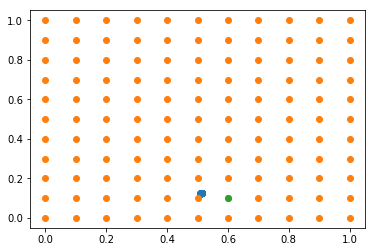

In [37]:
idx_no = 17
x_true = X_tst[idx_no][0]
print(x_true)
plt.scatter(mis[-1, :, idx_no, 0, 0], mis[-1, :, idx_no, 0, 1])
plt.scatter(mis[0, :, idx_no, 0, 0], mis[0, :, idx_no, 0, 1])
plt.scatter(x_true[0], x_true[1])

r = (Da - 1)//(Dm - 1)
idx_all = idx_no//11 * Da * r + idx_no%11 * r
print(X_tst_all[idx_all][0])

u_mis = compute_utility(x_true, alloc, pay)
u_true = (X_tst_all[idx_all][0] *  alloc[idx_all][0]).sum() - pay[idx_all][0]
u_img = compute_utility(x_true, alloc, pay).reshape(Da, Da)[::-1, :] - u_true
print(u_img.max())

In [ ]:
mis_all = mis
mis_no = np.random.permutation(Dm**2)[:15]

x1 = (2.0 - np.sqrt(2.0))/3.0
x2 = 2.0/3.0

D0 = Da

vis_dir = "vis_tmp"
if not os.path.exists(vis_dir): os.mkdir(vis_dir)

it = 0
while it < 2001:
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))
    fig.tight_layout();
    
    im_plot = ax.imshow(u_img, extent=[0, 1, 0, 1], vmin = u_img.min(), vmax=u_img.max())
    plt.colorbar(im_plot, ax = ax,fraction=0.046, pad=0.04)
    
        
    ax.plot(np.linspace(x1,x1), np.linspace(1,x2), linewidth = 2, linestyle = '--', c='black')
    ax.plot(np.linspace(x1,x2), np.linspace(x2,x1), linewidth = 2, linestyle = '--', c='black')
    ax.plot(np.linspace(x2,x2), np.linspace(x1,0.0), linewidth = 2, linestyle = '--', c='black')
    ax.plot(np.linspace(0.0,x1), np.linspace(x2,x2), linewidth = 2, linestyle = '--', c='black')
    ax.plot(np.linspace(x2,1.0), np.linspace(x1,x1), linewidth = 2, linestyle = '--', c='black')

    ax.plot(mis_all[:it+1, mis_no, idx_no, 0,  0], mis_all[:it+1, mis_no, idx_no, 0,  1], '--')
    ms, = ax.plot(mis_all[0, mis_no, idx_no, 0,  0], mis_all[0, mis_no, idx_no, 0,  1], 'rx')
    me, = ax.plot(mis_all[it, mis_no, idx_no, 0,  0], mis_all[it, mis_no, idx_no, 0,  1], 'ro')
    v, = ax.plot(x_true[0], x_true[1], 'go', markersize=9)
    
    ax.set_xlabel("mis_v1")
    ax.set_ylabel("mis_v2")
    ax.set_title("U_mis - U_true | Iter: %d"%it)  
    
    
    ax.legend([v, ms, me], ['v_true', 'mis_init', 'mis_curr'], loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=3, fancybox=True, shadow=True)
    
    

    fig.savefig(os.path.join(vis_dir, "tmp" + str(it) + ".png"), bbox_inches='tight',dpi=60)
    plt.close()
    
    if it < 50: it += 2
    elif it < 200: it += 10
    else: it += 100
    print("Processed %d of %d imgs"%(it, 2000))

os.chdir(vis_dir)
cmd_str = "convert -delay 20 -loop 0 `ls -v` %s"%(os.path.join("../", vis_dir + ".gif"))
print("Running: %s"%cmd_str)
os.system(cmd_str)
os.chdir("..")

out_fname = os.path.join(cfg.dir_name, "%d_vis_%.2fx%.2f.gif"%(cfg.test.restore_iter, x_true[0], x_true[1]))
print("Output file: %s"%out_fname)
shutil.move(vis_dir + ".gif", out_fname)
shutil.rmtree(vis_dir)

Processed 2 of 2000 imgs
Processed 4 of 2000 imgs
Processed 6 of 2000 imgs
Processed 8 of 2000 imgs
Processed 10 of 2000 imgs
Processed 12 of 2000 imgs
Processed 14 of 2000 imgs
Processed 16 of 2000 imgs
Processed 18 of 2000 imgs
Processed 20 of 2000 imgs
Processed 22 of 2000 imgs
Processed 24 of 2000 imgs
Processed 26 of 2000 imgs
Processed 28 of 2000 imgs
Processed 30 of 2000 imgs
Processed 32 of 2000 imgs
Processed 34 of 2000 imgs
Processed 36 of 2000 imgs
Processed 38 of 2000 imgs
Processed 40 of 2000 imgs
Processed 42 of 2000 imgs
Processed 44 of 2000 imgs
Processed 46 of 2000 imgs
Processed 48 of 2000 imgs
Processed 50 of 2000 imgs
Processed 60 of 2000 imgs
Processed 70 of 2000 imgs
Processed 80 of 2000 imgs
Processed 90 of 2000 imgs
Processed 100 of 2000 imgs
